# Blocks example: training an MLP on MNIST

This notebooks is based on the [introduction tutorial](http://blocks.readthedocs.org/en/latest/tutorial.html) in the Blocks documentation.

In [2]:
import numpy as np
from matplotlib import cm, pyplot as plt
%matplotlib inline

In [3]:
import blocks

In [4]:
from theano import tensor
x = tensor.matrix('features')

### Building the model

#### Long way

In [5]:
from blocks.bricks import Linear, Rectifier, Softmax
input_to_hidden = Linear(name='input_to_hidden', input_dim=784, output_dim=100)
h = Rectifier().apply(input_to_hidden.apply(x))
hidden_to_output = Linear(name='hidden_to_output', input_dim=100, output_dim=10)
y_hat = Softmax().apply(hidden_to_output.apply(h))

In [6]:
y = tensor.lmatrix('targets')
from blocks.bricks.cost import CategoricalCrossEntropy
cost = CategoricalCrossEntropy().apply(y.flatten(), y_hat)

#### Short way

In [7]:
from blocks.bricks import WEIGHT
from blocks.graph import ComputationGraph
from blocks.filter import VariableFilter
cg = ComputationGraph(cost)
W1, W2 = VariableFilter(roles=[WEIGHT])(cg.variables)
cost = cost + 0.005 * (W1 ** 2).sum() + 0.005 * (W2 ** 2).sum()
cost.name = 'cost_with_regularization'

In [8]:
from blocks.bricks import MLP
mlp = MLP(activations=[Rectifier(), Softmax()], dims=[784, 100, 10]).apply(x)

### Initialize the model

In [9]:
from blocks.initialization import IsotropicGaussian, Constant
input_to_hidden.weights_init = hidden_to_output.weights_init = IsotropicGaussian(0.01)
input_to_hidden.biases_init = hidden_to_output.biases_init = Constant(0)
input_to_hidden.initialize()
hidden_to_output.initialize()

In [10]:
before_training = W1.get_value() 
before_training

array([[ 0.00764556, -0.01124291, -0.00137316, ...,  0.00715281,
        -0.00843766,  0.00726915],
       [-0.00300742, -0.00752019,  0.00470734, ...,  0.01553072,
         0.00510337, -0.00332438],
       [-0.00816994, -0.00480912, -0.00021066, ..., -0.01991693,
        -0.00769432, -0.00765804],
       ..., 
       [ 0.00511479,  0.00822329, -0.02027499, ..., -0.01535202,
        -0.00611927,  0.00228889],
       [ 0.00611224,  0.01116154,  0.00436344, ...,  0.00152842,
         0.00196134,  0.00373074],
       [ 0.01813583,  0.00565259,  0.00071371, ...,  0.00566098,
        -0.01152798,  0.01192834]])

### Visualize before training

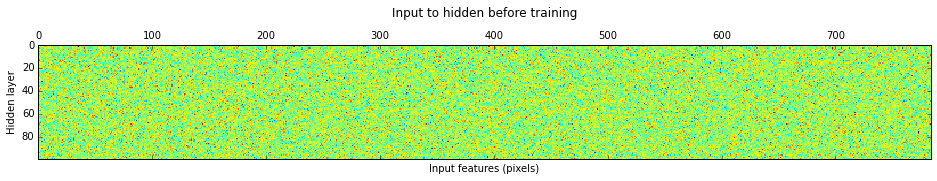

In [11]:
plt.matshow(before_training.transpose());
plt.title('Input to hidden before training', y=1.2);
plt.xlabel('Input features (pixels)');
plt.ylabel('Hidden layer');

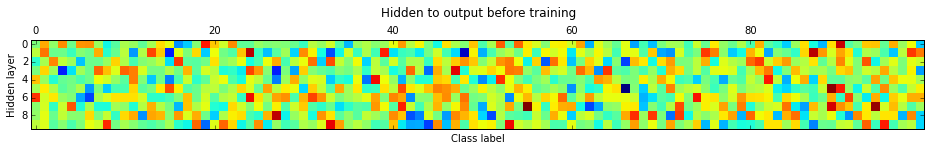

In [12]:
plt.matshow(W2.get_value().transpose(), interpolation='nearest');
plt.title('Hidden to output before training', y=1.2);
plt.xlabel('Class label');
plt.ylabel('Hidden layer');

### Load the MNIST digit dataset

In [13]:
import h5py

In [14]:
from fuel.datasets import MNIST
mnist = MNIST(("train",))

In [15]:
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme
from fuel.transformers import Flatten
data_stream = Flatten(DataStream.default_stream(
        mnist,
        iteration_scheme=SequentialScheme(mnist.num_examples, batch_size=256)))

### Training

In [16]:
from blocks.algorithms import GradientDescent, Scale
algorithm = GradientDescent(cost=cost, params=cg.parameters, step_rule=Scale(learning_rate=0.1))

In [17]:
mnist_test = MNIST(("test",))
data_stream_test = Flatten(DataStream.default_stream(
        mnist_test, 
        iteration_scheme=SequentialScheme(mnist_test.num_examples, batch_size=1024)))

In [18]:
from blocks.extensions.monitoring import DataStreamMonitoring
monitor = DataStreamMonitoring(variables=[cost], data_stream=data_stream_test, prefix="test")

In [19]:
from blocks.main_loop import MainLoop
from blocks.extensions import FinishAfter, Printing
main_loop = MainLoop(data_stream=data_stream, 
                     algorithm=algorithm, 
                     extensions=[monitor, FinishAfter(after_n_epochs=10), Printing()])
main_loop.run() 


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 test_cost_with_regularization: 2.341906692182037


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 235
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 235:
	 test_cost_with_regularization: 0.657896590086654


--------------------

### Visualize after training

In [20]:
np.shape(W1.get_value())

(784, 100)

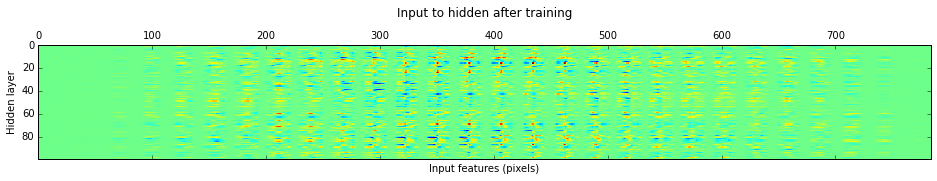

In [21]:
plt.matshow(W1.get_value().transpose());
plt.title('Input to hidden after training', y=1.2);
plt.xlabel('Input features (pixels)');
plt.ylabel('Hidden layer');

In [22]:
np.shape(W2.get_value())

(100, 10)

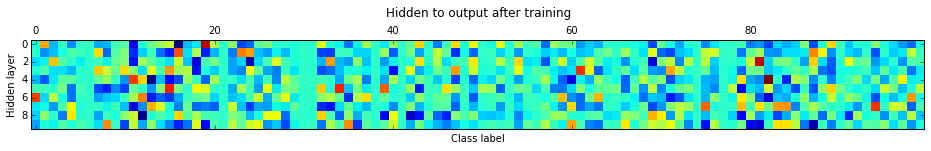

In [23]:
plt.matshow(W2.get_value().transpose(), interpolation='nearest');
plt.title('Hidden to output after training', y=1.2);
plt.xlabel('Class label');
plt.ylabel('Hidden layer');

In [24]:
cg.auxiliary_variables

[W_norm, b_norm, W_norm, b_norm]

In [25]:
cg.parameters

[b, b, W, W]

In [26]:
len(cg.parameters[0].get_value())

10

In [27]:
cg.parameters[0].get_value()

array([-0.31776704,  0.46469967, -0.09174638, -0.19599784,  0.17148552,
        0.49950101, -0.06921681,  0.30742403, -0.75866715, -0.00971502])

In [28]:
len(cg.parameters[1].get_value())

100

In [29]:
cg.inputs

[targets, features]

In [30]:
cg.outputs

[categoricalcrossentropy_apply_cost]

### Visualize digits

In [31]:
datapoints = mnist.get_data(request=[0,1,2])

In [32]:
datapoints

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ..., 
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ..., 
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ..., 
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8), array([[5],
        [0],
        [4]], dtype=uint8))

In [33]:
digit1 = datapoints[0][0][0]

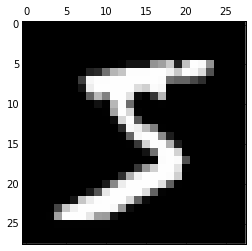

In [34]:
plt.matshow(digit1, interpolation='none', cmap = cm.Greys_r);

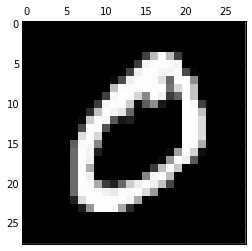

In [35]:
digit2 = datapoints[0][1][0]
plt.matshow(digit2, interpolation='none', cmap = cm.Greys_r);

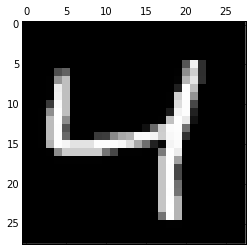

In [36]:
digit3 = datapoints[0][2][0]
plt.matshow(digit3, interpolation='none', cmap = cm.Greys_r);

In [37]:
mnist.axis_labels['features']

('batch', 'channel', 'height', 'width')

In [48]:
mnist_test.num_examples

10000

In [49]:
mnist.num_examples

60000